Multivariate time series prediction using LSTMs.  
Climate dataset with hourly granularity.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf

Using TensorFlow backend.


In [4]:
%matplotlib inline

# Load Dataset

In [5]:
climate_hour = pd.read_csv('data/climate_hour.csv')

In [6]:
climate_hour.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


# Data Exploration

In [5]:
climate_hour.isnull().sum()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

As expected, we see a seasonal trend to the data. It appears in the given data that there is a slight trend upward.

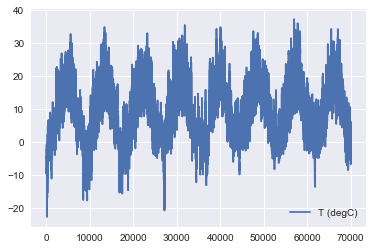

In [6]:
climate_hour[['Date Time', 'T (degC)']].plot()

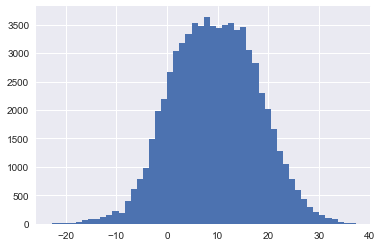

In [7]:
climate_hour['T (degC)'].hist(bins=50)

There are some features that are obiviously strongly correlated which could mean removal from the model.

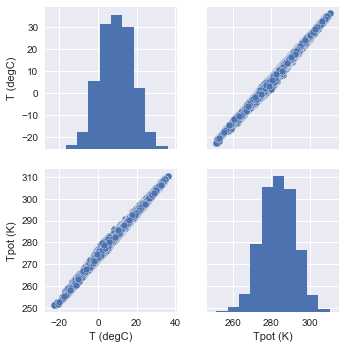

In [8]:
sns.pairplot(climate_hour[['T (degC)', 'Tpot (K)']].sample(frac=.3))

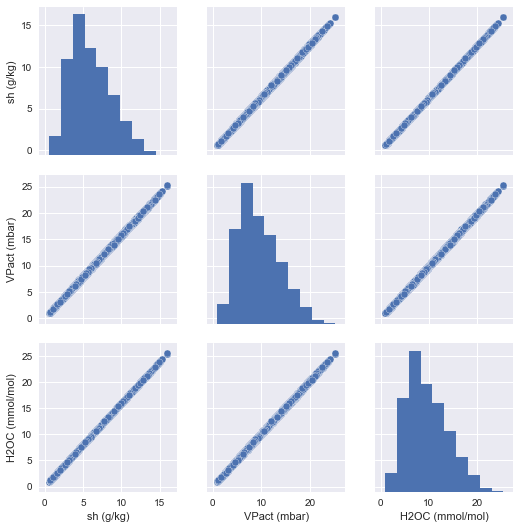

In [9]:
sns.pairplot(climate_hour[['sh (g/kg)', 'VPact (mbar)', 'H2OC (mmol/mol)']].sample(frac=.3))

Interestingly, the highest wind velocities are in the middle of the temperature distribution

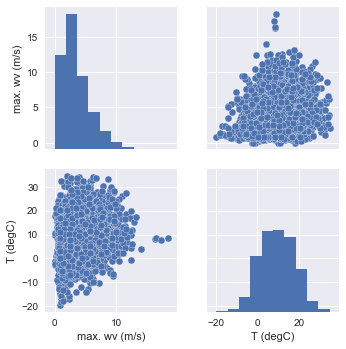

In [12]:
sns.pairplot(climate_hour[['max. wv (m/s)', 'T (degC)']].sample(frac=.05))

# Prepare Data for Modeling

In [7]:
climate_hour_index = climate_hour['Date Time']
climate_hour['Date Time'] = pd.to_datetime(climate_hour['Date Time'])
climate_hour['y'] = climate_hour['T (degC)'].shift(periods=-1)
climate_hour.dropna(inplace=True)
df_dev = climate_hour.loc[climate_hour['Date Time'] < '2015-01-01']
df_test = climate_hour.loc[climate_hour['Date Time'] >= '2014-12-31']

In [8]:
df_dev.drop('Date Time', axis=1, inplace=True)
df_test.drop('Date Time', axis=1, inplace=True)

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
df_dev_x = scaler_x.fit_transform(df_dev.iloc[:, :-1])
df_dev_y = scaler_y.fit_transform(df_dev.iloc[:, -1].values.reshape(-1, 1))
df_test_x = scaler_x.transform(df_test.iloc[:, :-1])
df_test_y = scaler_y.transform(df_test.iloc[:, -1].values.reshape(-1, 1))

df_dev = np.append(df_dev_x, df_dev_y, axis=1)
df_test = np.append(df_test_x, df_test_y, axis=1)

In [10]:
def create_dataset(data, window=1):
    new_x = np.ndarray((data.shape[0]-window, window, data.shape[1]-1))
    if isinstance(data, pd.DataFrame):
        data = data.values
    for idx in range(window, data.shape[0]):
        new_x[idx-window] = data[idx-window: idx, :-1]
        
    new_y = data[window:, -1].reshape(-1, 1)
    return new_x, new_y

In [11]:
df_dev_x, df_dev_y = create_dataset(df_dev, window=24)
df_test_x, df_test_y = create_dataset(df_test, window=24)

# Pre modeling error handling

Run sometimes if fitting gives an error

In [18]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [19]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12473532362692194108
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2224278732
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14995601001793356819
physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [20]:
np.random.seed(1234)

In [21]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.90)
sess = tf.Session(config=tf.ConfigProto(
  allow_soft_placement=True, log_device_placement=True))

In [22]:
sess.list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 17665963509196738293),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 2224278732, 17084571581949035780)]

In [24]:
from keras.optimizers import Adam

# Modeling

In [2]:
# Base Model after 500 epochs
model = Sequential()
model.add(LSTM(240, input_shape=df_dev_x[0].shape))
model.add(Dense(1, activation='linear'))
model.compile(loss='mae', optimizer=Adam(lr=0.001))
print(model.summary())
model.fit(df_dev_x, df_dev_y, validation_data=(df_test_x, df_test_y), epochs=100, batch_size=5000)

NameError: name 'Sequential' is not defined

In [ ]:
pd.DataFrame(model.history.history).plot()

y_true = scaler_y.inverse_transform(df_test_y)
y_pred = scaler_y.inverse_transform(model.predict(df_test_x))
mean_absolute_error(y_true, y_pred)

In [33]:
# Adding More unites to LSTM
model2 = Sequential()
model2.add(LSTM(24, input_shape=df_dev_x[0].shape))
model2.add(Dense(1, activation='linear'))
model2.compile(loss='mae', optimizer=Adam(lr=0.001))
print(model2.summary())
model2.fit(df_dev_x, df_dev_y, validation_data=(df_test_x, df_test_y), epochs=5, batch_size=5000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 24)                3744      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 3,769
Trainable params: 3,769
Non-trainable params: 0
_________________________________________________________________
None
Train on 52542 samples, validate on 17470 samples
Epoch 1/5
52542/52542 [==============================] - 3s 52us/step - loss: 0.3792 - val_loss: 0.1483
Epoch 2/5
52542/52542 [==============================] - 1s 19us/step - loss: 0.1305 - val_loss: 0.1176
Epoch 3/5
52542/52542 [==============================] - 1s 20us/step - loss: 0.0969 - val_loss: 0.0866
Epoch 4/5
52542/52542 [==============================] - 1s 17us/step - loss: 0.0733 - val_loss: 0.0579
Epoch 5/5
52542/52542 [==============================] - 1s 18us/

2.3725782423107487

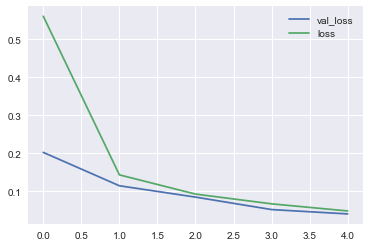

In [28]:
pd.DataFrame(model2.history.history).plot()

y_true = scaler_y.inverse_transform(df_test_y)
y_pred = scaler_y.inverse_transform(model2.predict(df_test_x))
mean_absolute_error(y_true, y_pred)

In [ ]:
pd.DataFrame(model2.history.history).iloc[50:].plot()

In [29]:
# Adding more LSTM layers
model3 = Sequential()
model3.add(LSTM(24, input_shape=df_dev_x[0].shape, return_sequences=True))
model.add(Dropout(.2))
model3.add(LSTM(24))
model.add(Dropout(.2))
model3.add(Dense(1, activation='linear'))
model3.compile(loss='mae', optimizer=Adam(lr=0.01, decay=0.0001))
print(model3.summary())
model3.fit(df_dev_x, df_dev_y, validation_data=(df_test_x, df_test_y), epochs=5, batch_size=5000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 24, 24)            3744      
_________________________________________________________________
lstm_4 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 8,473
Trainable params: 8,473
Non-trainable params: 0
_________________________________________________________________
None
Train on 52542 samples, validate on 17470 samples
Epoch 1/5
52542/52542 [==============================] - 3s 61us/step - loss: 0.1176 - val_loss: 0.0522
Epoch 2/5
52542/52542 [==============================] - 2s 32us/step - loss: 0.0536 - val_loss: 0.0479
Epoch 3/5
52542/52542 [==============================] - 2s 40us/step - loss: 0.0439 - val_loss: 0.0410
Epoch 4/5
52542/52542 [==============

1.6429555830992482

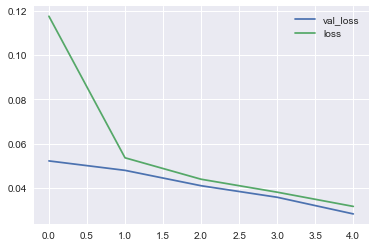

In [30]:
pd.DataFrame(model3.history.history).plot()

y_true = scaler_y.inverse_transform(df_test_y)
y_pred = scaler_y.inverse_transform(model3.predict(df_test_x))
mean_absolute_error(y_true, y_pred)

0.79 MAE but big variance variance between epochs.

In [ ]:
# Adding Statefulness to the model
model4 = Sequential()
model4.add(LSTM(24, batch_input_shape=(1, df_dev_x.shape[1], df_dev_x.shape[2]), stateful=True))
model4.add(Dense(1, activation='linear'))
model4.compile(loss='mae', optimizer=Adam(lr=0.001))
print(model4.summary())
model4.fit(df_dev_x, df_dev_y, validation_data=(df_test_x, df_test_y), epochs=5, batch_size=1)

In [ ]:
pd.DataFrame(model4.history.history).iloc[5:].plot()

y_true = scaler_y.inverse_transform(df_test_y)
y_pred = scaler_y.inverse_transform(model4.predict(df_test_x))
mean_absolute_error(y_true, y_pred)

In [31]:
# Deeper layer with 4 LSTM layers
model5 = Sequential()
model5.add(LSTM(24, input_shape=df_dev_x[0].shape, return_sequences=True))
model5.add(Dropout(.2))
model5.add(LSTM(24, input_shape=df_dev_x[0].shape, return_sequences=True))
model5.add(Dropout(.2))
model5.add(LSTM(24, input_shape=df_dev_x[0].shape, return_sequences=True))
model5.add(Dropout(.2))
model5.add(LSTM(24, input_shape=df_dev_x[0].shape))
model5.add(Dropout(.2))
model5.add(Dense(1, activation='linear'))
model5.compile(loss='mae', optimizer=Adam(lr=0.01))
print(model5.summary())
model5.fit(df_dev_x, df_dev_y, validation_data=(df_test_x, df_test_y), epochs=5, batch_size=5000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 24, 24)            3744      
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 24)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 24, 24)            4704      
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 24, 24)            4704      
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 24)                4704      
__________

3.2143136442918245

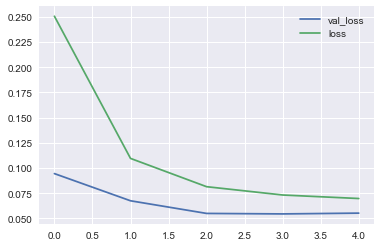

In [32]:
pd.DataFrame(model5.history.history).plot()

y_true = scaler_y.inverse_transform(df_test_y)
y_pred = scaler_y.inverse_transform(model5.predict(df_test_x))
mean_absolute_error(y_true, y_pred)

# Write to file

In [ ]:
idx = climate_hour.loc[climate_hour['Date Time'] >= '2015-01-01'].index
labels = climate_hour_index[idx].reset_index(drop=True)

In [ ]:
labels.head()

In [ ]:
predictions = pd.DataFrame(y_pred)
predictions.columns = ['temperature']

predictions['date_time'] = labels

In [ ]:
predictions.to_csv('predictions2.csv', index=False)

In [ ]:
plt.plot(y_true[:250])
plt.plot(y_pred[:250])
plt.show()